# problem 1

In [233]:
import numpy as np
import matplotlib.pyplot as plt

def decisionWeights(m,c, prior = 1/2): # assumes prior = 1/2 as you are doing this with 2
    cinv = np.linalg.inv(c)
    w1 = -1/2*cinv
    w2 = cinv @ m.reshape(-1,1)
    w3 = -1/2* m @ cinv @ m.reshape(-1,1) - 1/2 *np.log(np.linalg.det(c))
    return (w1,w2,w3)

def evaluateDecision(x,weightsList): #weightsList is a a list of tuples (w1,w2,w3)
    #returns index of weight set that is greatest
    toMax = np.zeros(len(weightsList))
    for i in range(len(weightsList)):
        temp = weightsList[i]
        toMax[i] = x.reshape(1,-1) @ temp[0] @ x.reshape(-1,1) + temp[1].T @ x.reshape(-1,1)  + temp[2]

    return np.argmax(toMax)


def plotGaussiansAndDiscriminantFunc(m1,c1,m2,c2):
    data1 = np.random.multivariate_normal(m1, c1, 300)
    data2 = np.random.multivariate_normal(m2, c2, 300)
    
    temp = np.vstack((data1,data2))
    xsamps = np.linspace(np.min(temp[:,0]), np.max(temp[:,0]), 500)
    ysamps = np.linspace(np.min(temp[:,1]), np.max(temp[:,1]), 500)
    Xval,Yval  = np.meshgrid(xsamps,ysamps)
    dw1 = decisionWeights(m1,c1) #decisionweights 1 and 2
    dw2 = decisionWeights(m2,c2)
    classified = np.array([[evaluateDecision(np.array([x,y]),[dw1,dw2]) for x in Xval[0]] for y in Yval[:, 0]])

    plt.imshow(classified, extent=[np.min(temp[:,0])-2, np.max(temp[:,0]) + 2, np.min(temp[:,1])-2 , np.max(temp[:,1])+2], origin='lower', cmap='RdYlGn')

    plt.scatter(data1[:, 0], data1[:, 1], c='b', label='Gaussian 1')
    plt.scatter(data2[:, 0], data2[:, 1], c='r', label='Gaussian 2')


### Part A

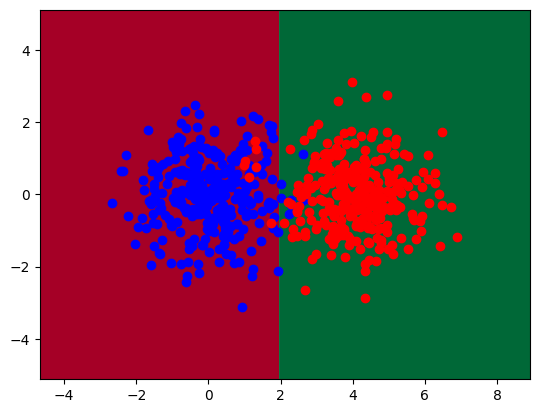

In [234]:
m1 = np.zeros(2)
m2 = np.zeros(2)
c1 = np.identity(2)
c2 = np.identity(2)

m2[0] = 4

plotGaussiansAndDiscriminantFunc(m1,c1,m2,c2)

### Part B

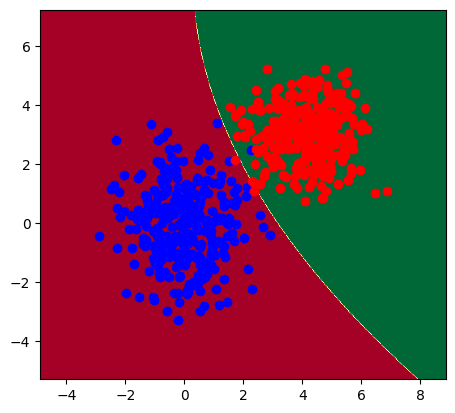

In [235]:
m1 = np.zeros(2)
m2 = np.zeros(2)
c1 = np.identity(2)
c2 = np.identity(2)
c1[1,1] = 2
m2[0] = 4
m2[1] = 3

plotGaussiansAndDiscriminantFunc(m1,c1,m2,c2)

### Part C

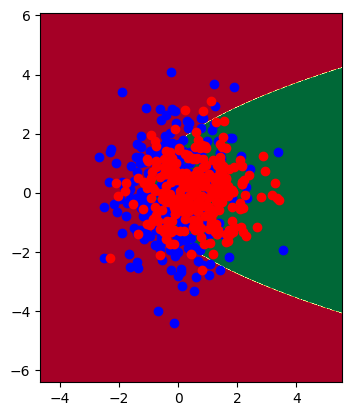

In [236]:
m1 = np.zeros(2)
m2 = np.zeros(2)
c1 = np.identity(2)
c2 = np.identity(2)
c1[1,1] = 2
m2[0] = 1/2

plotGaussiansAndDiscriminantFunc(m1,c1,m2,c2)

### Part D

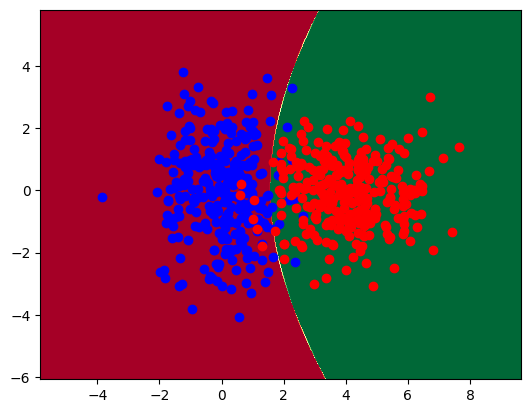

In [237]:
m1 = np.zeros(2)
m2 = np.zeros(2)
c1 = np.identity(2)
c2 = np.identity(2)
c1[1,1] = 2
c2[0,0] = 2
m2[0] = 4

plotGaussiansAndDiscriminantFunc(m1,c1,m2,c2)

# Problem 2

In [238]:
data = np.load('digits-labels.npz')
digits = data['d']  
labels = data['l']  
print(digits.shape)

(784, 10000)


In [239]:
temp = np.argsort(labels)
labels = np.sort(labels)
digits= digits[:,temp]
changeidx = np.where((labels - np.roll(labels,1)) == 1)
changeidx =changeidx[0]

In [240]:
# this code is so bad but it works
#Note to self in future grab random 100 indices from each class and then just use the rest for the test set. Lesson learned: If it feels overcomplicated it probably is
training = np.zeros((digits.shape[0],1000))
test = np.zeros((digits.shape[0],digits.shape[1] - 1000))
trainLabels = np.zeros(1000)
testLabels = np.zeros(digits.shape[1] - 1000)
testIdx = 0
trainingIdx = 0
for i in range(digits.shape[1]):
    if(trainingIdx % 100 == 0 and trainingIdx != 0):
        if i in changeidx:
            training[:,trainingIdx] = digits[:,i]
            trainLabels[trainingIdx]  = labels[i]
            trainingIdx +=1
            continue
        test[:,testIdx] = digits[:,i]
        testLabels[testIdx] = labels[i]
        testIdx +=1
    else:
        training[:,trainingIdx] = digits[:,i]
        trainLabels[trainingIdx]  = labels[i]
        trainingIdx +=1

In [241]:
def pca(data): #takes input data as columns and expects it to be 0 mean (add mean back later if intended)
        covariance_matrix = np.dot(data,data.T)/(data.shape[1])
        eigvals, eigvecs = np.linalg.eigh(covariance_matrix)
        eigvals = eigvals[::-1]
        eigvecs = eigvecs[:,::-1]

        return (eigvecs,eigvals)

trainingMean = np.mean(training,axis=1).reshape(-1,1)
trainnormed = training - trainingMean
eigvecs, eigvals = pca(trainnormed)
PCAmat = eigvecs.T

In [242]:
numComponents = 16
reducedTrain = PCAmat[:numComponents] @ trainnormed
classMeans = np.zeros((10,numComponents))
classCovariances = np.zeros((10,numComponents, numComponents))
weightList = [] # list of tuple containing discriminant function weights for gaussian based on 545 lecture 9 slide 34
#note weightlist has a tuple for each digit 0 to 9 in order
for i in range(10):
    tempdata = reducedTrain[:,i*100: i*100 + 100]
    classMeans[i] = np.mean(tempdata,axis=1)
    classCovariances[i] = 1/100*(tempdata-classMeans[i].reshape(-1,1)) @ (tempdata- classMeans[i].reshape(-1,1)).T
    weightList.append(decisionWeights(classMeans[i], classCovariances[i]))
    

### Testing on test set of digits

In [243]:
predictions = np.zeros(testLabels.shape[0])
for i in range(testLabels.shape[0]):
    normReducedDatapoint = PCAmat[:numComponents] @ (test[:,i].reshape(-1,1) - trainingMean)
    predictions[i] = int(evaluateDecision(normReducedDatapoint, weightList))

In [244]:
conf_matrix = np.zeros((10, 10))  
for i in range(len(testLabels)):
    true_label = int(testLabels[i])
    pred_label = int(predictions[i])
    conf_matrix[true_label][pred_label] += 1
    
print(f"Total Accuracy for {numComponents} PCA Components: {np.sum(np.diag(conf_matrix))/len(testLabels)}")

Total Accuracy for 16 PCA Components: 0.9064444444444445


## Conclusion:  

It takes a minimum of 16 PCA components to get an accuracy above 90%

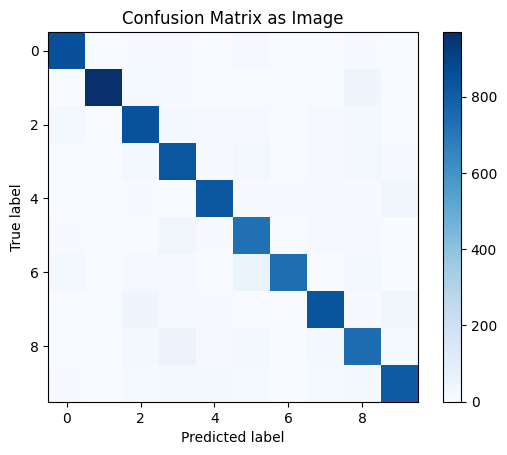

In [245]:
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix as Image')
plt.colorbar()
tick_marks = np.arange(3)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


### Extra Credit

  Taking PCAreduced version of Training data and looking to use LDA

In [246]:
LDAtrain  = reducedTrain.copy()
ldaLabels = trainLabels.copy()


dimensionality = LDAtrain.shape[0]
from scipy.linalg import eigh

BetweenCov = np.zeros((dimensionality,dimensionality)) # since nfft +1 as we cut specotrgram and keep DC term
WithinCov = np.zeros((dimensionality,dimensionality))
ldaTotalMean = np.mean(LDAtrain, axis = 1)
ldaClassMeans = []

for i in range(10):
    tempdata = LDAtrain[:,i*100: i*100 + 100]
    currmean = np.mean(tempdata,axis=1)
    ldaClassMeans.append(currmean)
    BetweenCov += (currmean - ldaTotalMean).reshape(-1,1) @ (currmean - ldaTotalMean).reshape(1,-1)

for i in range(10):
    for j in range(100):
        tempdata = LDAtrain[:,i*100 + j]
        left = (tempdata.reshape(-1,1) - ldaClassMeans[i].reshape(-1,1))
        right = (tempdata.reshape(1,-1) - ldaClassMeans[i].reshape(1,-1))
        WithinCov += left@ right

geneigvals, geneigvecs = eigh(BetweenCov, WithinCov, eigvals_only=False)

geneigvals = geneigvals[::-1]
geneigvecs =  geneigvecs[:,::-1]

geneigvecs = geneigvecs.T



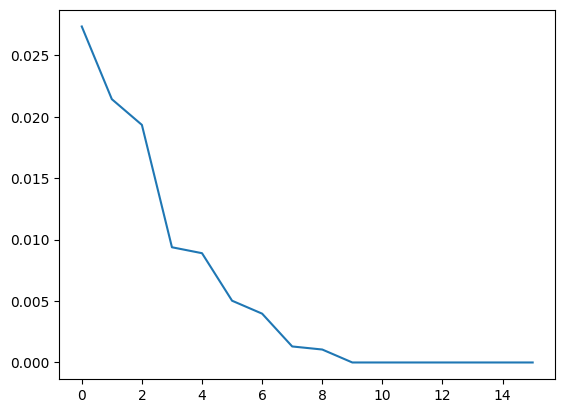

In [247]:
plt.plot(geneigvals)

Looks like we use 9 LDA vectors

In [263]:
LDAmat = geneigvecs

Lets use KNN on the output from projecting to the 9 LDA vectors!!!! I didn't implement since I implemented LDA and I figured this was very simple enough

In [264]:
trainData = LDAmat @ (LDAtrain - ldaTotalMean.reshape(-1,1))
testData = LDAmat @ ((PCAmat[:numComponents] @ (test-trainingMean)) - ldaTotalMean.reshape(-1,1))


In [265]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(trainData.T, trainLabels)
y_pred = knn.predict(testData.T)

accuracy = accuracy_score(testLabels, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.89


### We perform slightly below 90%